In [ ]:
# default_exp datasets

# Datasets

> Loading data for training DL models.

In [1]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# hide
from nbdev.showdoc import *

In [3]:
# export
from steel_segmentation.metadata import *
from steel_segmentation.masks import *

from fastcore.test import *
from fastai.vision.all import *
from PIL import Image
from collections import defaultdict
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import os
import cv2

from torch.utils.data import Dataset, sampler
from albumentations import (
    HorizontalFlip, ShiftScaleRotate, Resize, Compose, GaussNoise)
from albumentations.pytorch import ToTensor
import albumentations as alb

In [ ]:
# hide
only_imgs = ["0a1cade03.jpg", "bca4ae758.jpg", "988cf521f.jpg", "b6a257b28.jpg",
             "b2ad335bf.jpg", "72aaba8ad.jpg", "f383950e8.jpg"]
train = train[train["ImageId"].isin(only_imgs)].copy()
train_all = train_all[train_all["ImageId"].isin(only_imgs)].copy()
train_multi = train_multi[train_multi["ImageId"].isin(only_imgs)].copy()

## Fast.ai DataBlock API

Fast.ai Datablock API to create `fastai.data.core.Datasets` class.

### Classification

In [ ]:
#hide
size = None

In [ ]:
b_tfms = aug_transforms(
            size=size if size else (256, 1600),
            max_warp=.1,
            max_rotate=5.,
            max_lighting=0.1)

In [ ]:
b_tfms

[Flip -- {'size': (256, 1600), 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5}:
 encodes: (TensorImage,object) -> encodes
 (TensorMask,object) -> encodes
 (TensorBBox,object) -> encodes
 (TensorPoint,object) -> encodes
 decodes: ,
 Brightness -- {'max_lighting': 0.1, 'p': 1.0, 'draw': None, 'batch': False}:
 encodes: (TensorImage,object) -> encodes
 decodes: ]

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock()),
    get_x=ColReader(0, pref=train_path),
    get_y=ColReader(1, label_delim=' '),
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    batch_tfms=b_tfms)

Now we can check that all is alright passing a `source` into the `dblock` and the API returns all the process explained.

And then we can create a `Datasets` class.

In [ ]:
dsets = dblock.datasets(train_multi, verbose=True)

0        0002cc93b.jpg             1
1        00031f466.jpg             0
2        000418bfc.jpg             0
3        000789191.jpg             0
4        0007a71bf.jpg             3
...                ...           ...
12563    fff0295e1.jpg             0
12564    fff02e9c5.jpg             3
12565    fffe98443.jpg             3
12566    ffff4eaa8.jpg             3
12567    ffffd67df.jpg             3

[12568 rows x 2 columns]
Found 12568 items
2 datasets of sizes 10055,2513
Setting up Pipeline: ColReader -- {'cols': 0, 'pref': Path('../data/train_images'), 'suff': '', 'label_delim': None} -> PILBase.create
Setting up Pipeline: ColReader -- {'cols': 1, 'pref': '', 'suff': '', 'label_delim': ' '} -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} -> OneHotEncode -- {'c': None}


In [ ]:
len(dsets.train), len(dsets.valid), type(dsets.valid)

(10055, 2513, fastai.data.core.Datasets)

L'attributo `vocab` permette di visualizzare il dominio delle variabili dipendenti.

In [ ]:
dsets.vocab

['0', '1', '2', '3', '4']

L'istanza di dataset permette di ottenere una tupla `(x, y)` con `y` già codificato.

In [ ]:
t = dsets.train[-3]
t

(PILImage mode=RGB size=1600x256, TensorMultiCategory([0., 0., 0., 1., 1.]))

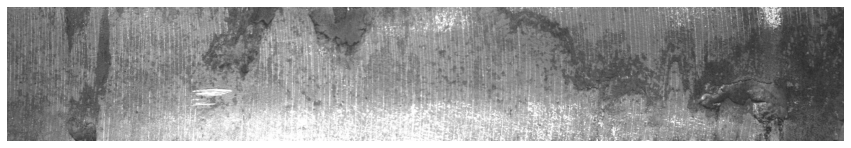

In [ ]:
show_image(t[0], figsize=(15,5));

Per visualizzare la label non codificata bisogna utilizzare il metodo `dsets.decode`

In [ ]:
t_decoded = dsets.decode(t)
t_decoded

(PILImage mode=RGB size=1600x256, (#2) ['3','4'])

### Segmentation

To get a `Datasets` object for training segmentation FastAI models, we need to: 
- load the training images
- load the corrisponding labels (saved in `labels_dir` by the `preprocessing` module with the `create_mask` function)
- pair the images with labels with a `Dataset`

In [ ]:
# export
classes = [0, 1, 2, 3, 4]

In [ ]:
#hide
size = (256,1600)

In [ ]:
btfms = aug_transforms(
            size=size, 
            max_warp=.1,
            max_rotate=5.,
            max_lighting=0.1)
btfms

[Flip -- {'size': (256, 1600), 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5}:
 encodes: (TensorImage,object) -> encodes
 (TensorMask,object) -> encodes
 (TensorBBox,object) -> encodes
 (TensorPoint,object) -> encodes
 decodes: ,
 Brightness -- {'max_lighting': 0.1, 'p': 1.0, 'draw': None, 'batch': False}:
 encodes: (TensorImage,object) -> encodes
 decodes: ]

In [ ]:
def get_x(s):
    img_name = s["ImageId"]
    return train_path / str(img_name)

def get_y(s):
    img_name = s["ImageId"].split(".")[0] + "_P.png"
    return labels_path / img_name

dblock = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes=classes)),
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    batch_tfms=btfms)

In [ ]:
dsets = dblock.datasets(train_multi, verbose=True)

0        0002cc93b.jpg             1
1        00031f466.jpg             0
2        000418bfc.jpg             0
3        000789191.jpg             0
4        0007a71bf.jpg             3
...                ...           ...
12563    fff0295e1.jpg             0
12564    fff02e9c5.jpg             3
12565    fffe98443.jpg             3
12566    ffff4eaa8.jpg             3
12567    ffffd67df.jpg             3

[12568 rows x 2 columns]
Found 12568 items
2 datasets of sizes 10055,2513
Setting up Pipeline: get_x -> PILBase.create
Setting up Pipeline: get_y -> PILBase.create


In [ ]:
t = dsets.train[-1]
t

(PILImage mode=RGB size=1600x256, PILMask mode=L size=1600x256)

In [ ]:
np.unique(t[1])

array([0, 3], dtype=uint8)

In [ ]:
t_decoded = dsets.decode(t)
t_decoded

(PILImage mode=RGB size=1600x256, PILMask mode=L size=1600x256)

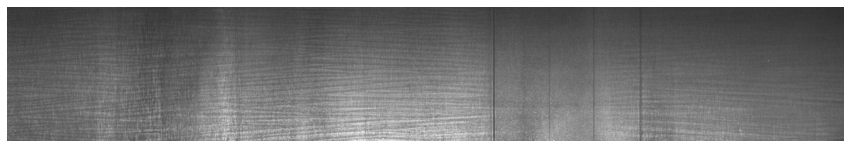

In [ ]:
img = t[0]
show_image(img, figsize=(15,5));

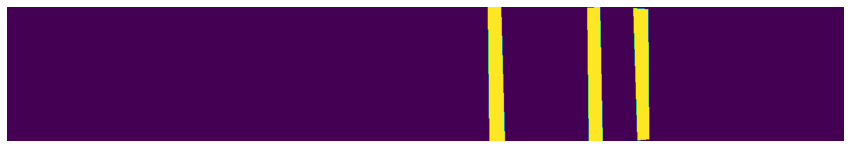

In [ ]:
mask = t[-1]
show_image(mask, figsize=(15,5));

In [ ]:
np.unique(mask)

array([0, 3], dtype=uint8)

## Pure Pytorch

The fast.ai Datablock API is very useful, we can load the images and apply transforms very quickly.
On the other side it can be a limit when experimenting with other models or with custom transformations and requires a deeper knoledge of the high-level API. 

Here some functions and classes from [this kernel](https://www.kaggle.com/rishabhiitbhu/unet-starter-kernel-pytorch-lb-0-88) for pure Pytorch `Dataset` and `DataLoader`.

In [4]:
# export
def get_transforms(phase, mean, std):
    list_transforms = []
    if phase == "train":
        list_transforms.extend(
            [
                HorizontalFlip(p=0.5),  # only horizontal flip for now
            ]
        )
    list_transforms.extend(
        [
            alb.Normalize(mean=mean, std=std, p=1),
            ToTensor(),
        ]
    )
    list_trfms = Compose(list_transforms)
    return list_trfms

In [5]:
get_tsfms = get_transforms('train', *imagenet_stats)
get_tsfms

Compose([
  HorizontalFlip(always_apply=False, p=0.5),
  Normalize(always_apply=False, p=1, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
  ToTensor(always_apply=True, p=1.0, num_classes=1, sigmoid=True, normalize=None),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})

In [6]:
# export
class SteelDataset(Dataset):

    def __init__(self, df, mean, std, phase):
        self.df = df
        self.mean = mean
        self.std = std
        self.phase = phase
        self.transforms = get_transforms(phase, mean, std)
        self.fnames = self.df.index.tolist()

    def __getitem__(self, idx):
        image_id, mask = make_mask(idx, df=self.df)
        image_path = train_path / image_id
        img = cv2.imread(str(image_path))
        augmented = self.transforms(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask']         # 1x256x1600x4
        mask = mask[0].permute(2, 0, 1)  # 4x256x1600
        return img, mask

    def __len__(self):
        return len(self.fnames)

In [7]:
steel_ds = SteelDataset(train_pivot, *imagenet_stats, 'train')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-1.8953) tensor(2.6400) torch.Size([4, 256, 1600])


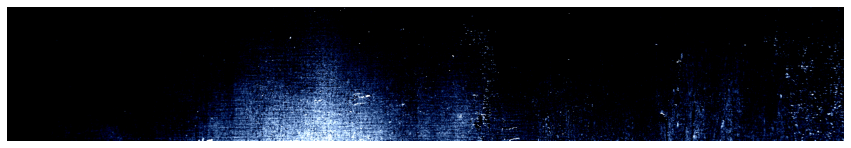

In [9]:
# missing
x,y = steel_ds[0]

print(x.min(), x.max(), y.shape)
show_image(x, figsize=(15,5));

In [16]:
get_tsfms.transforms

In [ ]:
# hide
from nbdev.export import notebook2script
notebook2script()

Converted 01_metadata.ipynb.
Converted 02_masks.ipynb.
Converted 03_datasets.ipynb.
Converted 04_dataloaders.ipynb.
Converted 05_metrics.ipynb.
Converted 06_trainer.ipynb.
Converted 07_predict.ipynb.
Converted index.ipynb.
